# Ridge Regression with Mini Batch Gradient Descent

My primary goal for this project is simply to build a Ridge Regressor that uses gradient descent from scratch, and to build the necessary functions to allow me to perform grid search cross validation in order to tune my hyperparameters.

My secondary goal is to try to find a simple model for predicting the percentage of earned grades of BC or lower for a given class. Because this is not the main goal here (I have extensively explored this topic elsewhere, see https://github.com/Rebekah73/GPA), I'm going to ignore all categorical variables. I'm also going to use a subset of 1000 samples from the data set in order to speed fitting.

I will code the necessary functions to perform a grid search cross validation to tune hyperparameters on a training subset, and then use the best combination to measure accuracy on my test subset.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import random
from collections import defaultdict
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
# loading the dataset

grades = pd.read_pickle("for_next_project.pkl").sample(1000)

grades.head()

,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,section_type,start_time,class_length,term_code,class_level,class_meetings,med_enrollment,number_sections
35144,0.463415,0.439024,0.097561,0.000000,0.0,0.000000,0.0,LEC,780.0,75.0,1104,6,2.0,45.0,2.0
45309,0.666667,0.166667,0.083333,0.083333,0.0,0.000000,0.0,LAB,800.0,50.0,1074,0,2.0,44.0,1.0
22402,0.583333,0.250000,0.083333,0.083333,0.0,0.000000,0.0,LAB,540.0,120.0,1092,3,2.0,15.0,1.0
50990,0.538462,0.461538,0.000000,0.000000,0.0,0.000000,0.0,LEC,870.0,150.0,1084,5,1.0,21.0,2.0
58371,0.125000,0.416667,0.250000,0.166667,0.0,0.041667,0.0,SEM,1020.0,120.0,1122,4,1.0,18.0,1.0


In [3]:
grades.columns.tolist()

['a_perc',
 'ab_perc',
 'b_perc',
 'bc_perc',
 'c_perc',
 'd_perc',
 'f_perc',
 'section_type',
 'start_time',
 'class_length',
 'term_code',
 'class_level',
 'class_meetings',
 'med_enrollment',
 'number_sections']

In [4]:
# The responses will be the sums of percentages of grades BC, C, D, and F

response_df = grades['bc_perc'] + grades['c_perc'] + grades['d_perc'] + grades['f_perc']

In [5]:
# The features include everything other than categorical variables and grade percentages

feature_df = grades[['start_time', 'class_length', 'term_code', 'class_level',
                 'class_meetings', 'med_enrollment', 'number_sections']]

The cost function that I'm dealing with here is 
$$
Cost(\beta) = \|y-X\beta\|^2 + \lambda \|\beta\|^2 
$$

Here $X$ is the matrix containing all of the observations, $y$ is the vector of observed response values, and $\beta$ is the coefficient vector.

So the first thing to do here is probably to figure out what the partial derivatives of this thing look like...

In [6]:
# converting features and responses into numpy arrays

features = np.array(feature_df)
response = np.array(response_df)

Next, I need a series of functions to create my model.

In [7]:
def normalized(X):
    
    """
    Computes the Euclidean distance between two points in  R^n

    Parameters
    ----------
    p1 : list or numpy array
        A point in R^n
    p2 : list or numpy array
        A second point in R^n

    Returns
    -------
    float
        The Euclidean distance between the two points

    """

    
    mean = np.mean(X, axis = 0)
    std = np.std(X, axis = 0)
        
    return (X-mean)/std, [mean, std]

In [8]:
# Normalizing the feature data

features, norm_params = normalized(features)

In [9]:
def train_test_split(X, y, frac):
    
    """
    Randomly splits a dataframe into training and testing data

    Parameters
    ----------
    X : numpy array
        feature data
    y : numpy array
        response data
    frac : float between 0 and 1
        the fraction of the observations to put in the training set

    Returns
    -------
    numpy arrays
        training feature data
        testing feature data
        training response data
        testing response data

    """
    
    # produce a list of indices for X and y and shuffle them randomly
    indices = list(range(X.shape[0]))
    random.shuffle(indices)
    
    # compute the number of indices for the test data
    split = int(len(indices)*frac)
    
    # split the indices into training and test indices
    train = indices[ :split]
    test = indices[split: ]
    
    # split X and y into training and test data
    
    X_train = X[train]
    X_test = X[test]
    
    y_train = y[train]
    y_test = y[test]
    
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, response, 0.8)

print("My training data has {} samples".format(len(X_train)))
print("My test data has {} samples".format(len(y_test)))

My training data has 800 samples
My test data has 200 samples


In [11]:
def y_pred(X, beta):
    
    """
    Computes the Euclidean distance between two points in  R^n

    Parameters
    ----------
    p1 : list or numpy array
        A point in R^n
    p2 : list or numpy array
        A second point in R^n

    Returns
    -------
    float
        The Euclidean distance between the two points

    """
    preds = np.dot(X, beta)
    
    return preds

In [12]:
def gradients(X, y, beta, lambd, bias = True):
    
    """
    Computes the Euclidean distance between two points in  R^n

    Parameters
    ----------
    p1 : list or numpy array
        A point in R^n
    p2 : list or numpy array
        A second point in R^n

    Returns
    -------
    float
        The Euclidean distance between the two points

    """
    
    grads = [0 for i in range(X.shape[1])]
    
    for j in range(X.shape[1]):
        if bias == True:
            if j != X.shape[1] -1:
                first_term = np.dot((y_pred(X, beta).reshape(1, -1) - y.reshape(1, -1)), X[:, j])/X.shape[0]
    
                grad = first_term[0] + 2 * lambd * beta[j]
                
            else:
                grad = (np.dot((y_pred(X, beta).reshape(1, -1) - y.reshape(1, -1)), X[:, j])/X.shape[0])[0]
            grads[j] = grad
        
        else:
            first_term = np.dot((y_pred(X, beta).reshape(1, -1) - y.reshape(1, -1)), X[:, j])/X.shape[0]
    
            grad = first_term[0] + 2 * lambd * beta[j]
            grads[j] = grad
    
    return grads

In [13]:
def norm_2_squared(z):
    
    """
    Computes the Euclidean distance between two points in  R^n

    Parameters
    ----------
    p1 : list or numpy array
        A point in R^n
    p2 : list or numpy array
        A second point in R^n

    Returns
    -------
    float
        The Euclidean distance between the two points

    """

    
    norm_2 = sum([i**2 for i in z])
    
    try:
        return norm_2[0]
    except:
        return norm_2

In [14]:
def norm_1(z):
    
    """
    Computes the Euclidean distance between two points in  R^n

    Parameters
    ----------
    p1 : list or numpy array
        A point in R^n
    p2 : list or numpy array
        A second point in R^n

    Returns
    -------
    float
        The Euclidean distance between the two points

    """

    
    norm = sum([abs(i) for i in z])
    
    try:
        return norm[0]
    except:
        return norm

In [15]:
def cost(X, y, beta, lambd, bias = True):
    
    """
    Computes the Euclidean distance between two points in  R^n

    Parameters
    ----------
    p1 : list or numpy array
        A point in R^n
    p2 : list or numpy array
        A second point in R^n

    Returns
    -------
    float
        The Euclidean distance between the two points

    """

    
    if bias == True:
    
        indices = [i for i in range(X.shape[1]) if i != bias]
    
        no_bias_beta = [beta[i] for i in indices]
    
        first_term = norm_2_squared(y.reshape(-1, 1) - y_pred(X, beta).reshape(-1, 1))/X.shape[1]

        second_term = lambd * norm_2_squared(no_bias_beta)
        
        total = first_term + second_term
        
    else:
        
        first_term = norm_2_squared(y.reshape(-1, 1) - y_pred(X, beta).reshape(-1, 1))/X.shape[1]
        
        second_term = lambd * norm_2_squared(beta)
            
        total = first_term + second_term
    
    return total

In [16]:
def find_alpha(X, y, beta, lambd, bias = True):
    
    """
    Computes the Euclidean distance between two points in  R^n

    Parameters
    ----------
    p1 : list or numpy array
        A point in R^n
    p2 : list or numpy array
        A second point in R^n

    Returns
    -------
    float
        The Euclidean distance between the two points

    """

    
    alpha = 1

    current_cost = cost(X, y, beta, lambd, bias)
    keep_going = True
    
    while keep_going:
                             
        grad = np.array(gradients(X, y, beta, lambd, bias))

        new_beta = beta - alpha * grad
        
        new_cost = cost(X, y, new_beta, lambd, bias)
        
        if new_cost > current_cost:
            alpha /= 2
        else:
            keep_going = False
            
    return alpha

In [17]:
def add_bias(X):
    
    """
    Computes the Euclidean distance between two points in  R^n

    Parameters
    ----------
    p1 : list or numpy array
        A point in R^n
    p2 : list or numpy array
        A second point in R^n

    Returns
    -------
    float
        The Euclidean distance between the two points

    """

    
    bias = np.array([1 for i in range(X.shape[0])]).reshape(-1, 1)
    
    X = np.append(X, bias, axis = 1)
    
    return X

In [18]:
def Ridge(X, y, lambd, epochs = 100, alpha_val = "find", bias = True):
    
    """
    Computes the Euclidean distance between two points in  R^n

    Parameters
    ----------
    p1 : list or numpy array
        A point in R^n
    p2 : list or numpy array
        A second point in R^n

    Returns
    -------
    float
        The Euclidean distance between the two points

    """

    if bias == True:
        
        X = add_bias(X)
    
    beta = np.array([random.random() for i in range(X.shape[1])])

    # keep track of all of the betas that you've found
        
    if alpha_val == "find":
        
        alpha = find_alpha(X, y, beta, lambd, bias)

    else:
        alpha = alpha_val
        
    print(alpha)
             
    costs = [cost(X, y, beta, lambd, bias)]
    for cycle in range(epochs):
                
        # compute the gradients
        
        grad = np.array(gradients(X, y, beta, lambd, bias))

        # update beta
        
        beta = beta - alpha * grad
        
        costs.append(cost(X, y, beta, lambd, bias))
    
    return beta, costs

In [19]:
b, c = Ridge(features, response, lambd = 10, epochs = 25, alpha_val = "find", bias = True)

print("My cost after 150 epochs is ", c[-1])
print("My final value of beta is {}".format(np.around(b, 5)))

0.0625
My cost after 150 epochs is  2.7836230670888753
My final value of beta is [-0.00092 -0.00127 -0.0003  -0.00201  0.00157  0.00228  0.00025  0.16409]


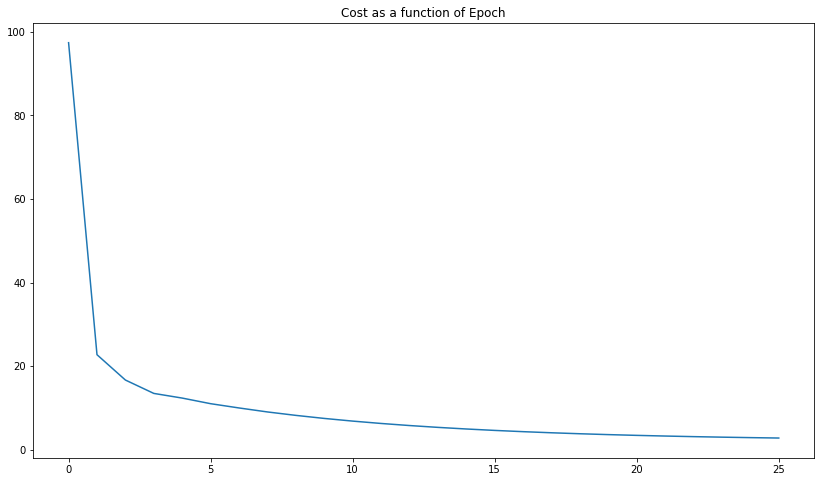

In [20]:
plt.figure(figsize = (14, 8))

plt.title("Cost as a function of Epoch")

sns.lineplot(x = list(range(len(c))), y = c)

xlabel = "Epochs"
ylabel = "Loss"

plt.show()
plt.close()

### Next I want to try to adapt what I have here to handle mini batch gradient descent, which really shouldn't be that big of a deal.

Here I'm going to assume that the dataset that I have is small enough so that my computer can fit all of it in memory, because I'm really not trying to deal with a complex situation here.

In [21]:
def batches(df, size):
    
    """
    Computes the Euclidean distance between two points in  R^n

    Parameters
    ----------
    p1 : list or numpy array
        A point in R^n
    p2 : list or numpy array
        A second point in R^n

    Returns
    -------
    float
        The Euclidean distance between the two points

    """

    
    indices = list(range(df.shape[0]))
    random.shuffle(indices)
    
    if size == "all":
        mini_batches = [indices]

    else:
        if len(indices)%size == 0:
            num_batches = len(indices) // size
            
        else:
            num_batches = 1 + len(indices) // size
    
        mini_batches = [indices[size * a : size * (a + 1)] for a in range(num_batches)]
    
    return mini_batches

In [22]:
def Ridge_MB(X, y, lambd, size = "all", epochs = 100, alpha_val = "find", bias = True):
    
    """
    Computes the Euclidean distance between two points in  R^n

    Parameters
    ----------
    p1 : list or numpy array
        A point in R^n
    p2 : list or numpy array
        A second point in R^n

    Returns
    -------
    float
        The Euclidean distance between the two points

    """
    
    # Add the bias term
    
    if bias == True:
        
        X = add_bias(X)
    
    # Randomly instantiate a starting beta
    
    beta = np.array([random.random() for i in range(X.shape[1])])

    # Assign alpha
    
    if alpha_val == "find":
        
        alpha = find_alpha(X, y, beta, lambd, bias)

    else:
        alpha = alpha_val
            
    # Compte the starting cost
    
    costs = [cost(X, y, beta, lambd, bias)]
    
    # produce the minibatches
    
    mini_batches = batches(X, size)
    
    # 
    
    for cycle in range(epochs):
        
        for batch in mini_batches:
                
            # compute the gradients
        
            grad = np.array(gradients(X[batch], y[batch], beta, lambd, bias))

            # update beta
        
            beta = beta - alpha * grad
        
            costs.append(cost(X, y, beta, lambd, bias))
    
    return beta, costs

In [23]:
b, c = Ridge_MB(features, response, 10, size = 10, epochs = 10, alpha_val = "find", bias = True)

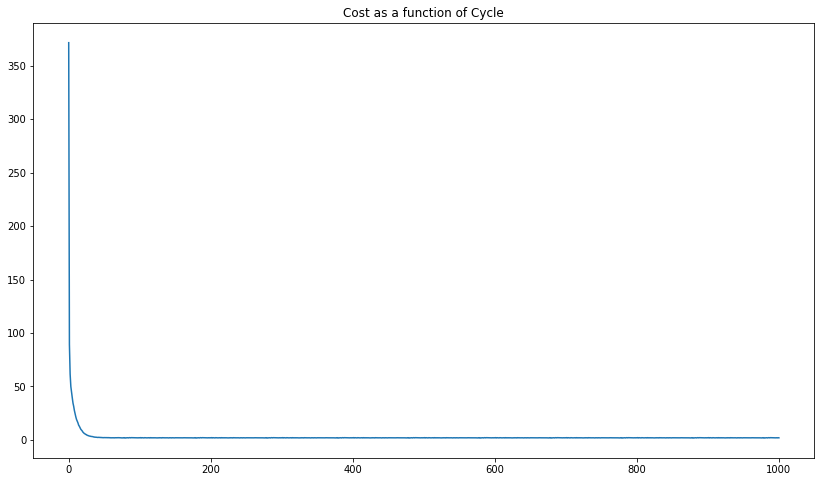

In [24]:
plt.figure(figsize = (14, 8))

plt.title("Cost as a function of Cycle")

sns.lineplot(x = list(range(len(c))), y = c)

xlabel = "Epochs"
ylabel = "Loss"

plt.show()
plt.close()

OK, so I'm relatively happy with what I've got here. However, I need to do something with it before I can consider this mini project to be complete. The obvious choice would be to build the necessary functions to split my data and to determine how well the model is performing on validation set, test set, etc. 

In [25]:
def RR_predict(X_test, beta, bias = True):
    
    """
    Computes the Euclidean distance between two points in  R^n

    Parameters
    ----------
    p1 : list or numpy array
        A point in R^n
    p2 : list or numpy array
        A second point in R^n

    Returns
    -------
    float
        The Euclidean distance between the two points

    """
    
    # Add a bias column if necessary
    
    if bias == True:
        X_test_bias = add_bias(X_test_bias)
    
    # Make the predictions
    
    predictions = y_pred(X_test_bias, beta)
    
    return predictions

In [26]:
def MSE(y, yhat):
    
    """
    Computes the Euclidean distance between two points in  R^n

    Parameters
    ----------
    p1 : list or numpy array
        A point in R^n
    p2 : list or numpy array
        A second point in R^n

    Returns
    -------
    float
        The Euclidean distance between the two points

    """

        
    return np.sum((y.reshape(-1, 1)-yhat)**2)/len(y)

In [27]:
def cross_valid_splits(X, k):

    """
    Randomly divides the rows of X into k equal groups

    Parameters
    ----------
    X : numpy array
    k : integer
        the number of (roughly equal) pieces into which to divide the data

    Returns
    -------
    list of lists
        A list of lists of indices assigned to each split
        
    """
    
    # find the indices of X and shuffles them
    indices = list(range(X.shape[0]))
    random.shuffle(indices)
    
    splits = []
    
    # compute the size of the splits
    if len(indices)%k == 0:
        length = int(len(indices)/k)
    else:
        length = len(indices)//k + 1
    
    # divides the shuffled list of indices into sublists of the correct length
    
    for i in range(k):
        
        split = indices[length*i: length*(i+1)]
        splits.append(split)
    
    
    return splits

In [28]:
def RR_CV(X, y, alphas, lambdas, epochs, sizes, folds = 3, bias = True, verbose = True):
    
    """
    Computes the Euclidean distance between two points in  R^n

    Parameters
    ----------
    p1 : list or numpy array
        A point in R^n
    p2 : list or numpy array
        A second point in R^n

    Returns
    -------
    float
        The Euclidean distance between the two points

    """

    combinations = []

    for lambd in lambdas:
        for size in sizes:
            for epoch in epochs:
                for alpha in alphas: 
                    combinations.append([lambd, size, epoch, alpha])
  
    best_combo = None
    best_error = np.inf
    
    for combo in combinations:
        
        # split the data into folds
        
        indices = list(range(len(X)))
        test_splits = cross_valid_splits(X, folds)
        
        # reset split_accuracies to an empty list
        split_errors = []
        
        for split in test_splits:
            
            # fitting the model to the data not found in the given split
            to_fit = list(set(indices) - set(split))
            
            b, c = Ridge_MB(X[to_fit], y[to_fit], combo[0], combo[1], combo[2], combo[3], bias = True)
            
            # making predictions and finding accuracy on the split data
            preds = y_pred(add_bias(X[to_fit]), b)
            error = MSE(preds, y[split])
            
            # appending the computed accuracy
            split_errors.append(error)
        
        # finding the mean of the accuracies for a given combination
        combo_error = np.mean(split_errors)
        if verbose == True:
            print('combo is: ', combo, 'MSE is:', combo_error)  
        
        # updating best_accuracy and best_combo if appropriate
        if combo_error < best_error:
            best_error = combo_error
            best_combo = combo
                
    return best_combo, best_error                        

In [29]:
alphas = [0.05, .01, .005]
lambdas = [1, 10, 100]
epochs = [5, 10, 50]
sizes = [1, 50, "all"]

In [ ]:
best_combo, best_error = RR_CV(X_train, y_train, alphas, lambdas, epochs, sizes, bias = True)

print("The best combo is:", best_combo, "The best_error is:", best_error)

combo is:  [1, 1, 5, 0.05] MSE is: 5.636670625961237
combo is:  [1, 1, 5, 0.01] MSE is: 4.657112383376183
combo is:  [1, 1, 5, 0.005] MSE is: 4.603203590029723
combo is:  [1, 1, 10, 0.05] MSE is: 5.945610267264492


In [ ]:
# Fitting to all of the training data with the best hyperparameters that we've found

b, c = Ridge_MB(X_train, y_train, best_combo[0], best_combo[1], best_combo[2], best_combo[3], bias = True)

# And then testing performance on the test set

test_preds = y_pred(add_bias(X_test), b)

test_MSE = MSE(test_preds, y_test)

print("The MSE on the test set of the model with tuned hyper parameters is: ", np.around(test_MSE, 4))
print("The best choice of hyper parameters is :")
print("                                 alpha : ", best_combo[0])
print("                                lambda : ", best_combo[1])
print("                                epochs : ", best_combo[2])
print("                            batch size : ", best_combo[3])

In [ ]:
plt.figure(figsize = (14, 8))

plt.title("Cost as a function of Epoch")

sns.lineplot(x = list(range(len(c))), y = c)

xlabel = "Epochs"
ylabel = "Loss"

plt.show()
plt.close()